# LSTM Threshold Strategy 

### References
https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.datacamp.com/tutorial/lstm-python-stock-market

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

import yfinance as yf
from backtesting import Strategy, Backtest 
from backtesting.lib import crossover

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
def get_raw_data(name, start_time="2000-01-01", end_time="2020-01-01"):
    ticker = yf.Ticker(name)
    data = ticker.history(start=start_time, end=end_time)

    plt.figure(figsize = (18,9))
    plt.plot(range(data.shape[0]),data['Close'], color='purple')
    plt.title(name + ' Raw Data')
    plt.xticks(range(0,data.shape[0],500),data.index[::500],rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    return data 


In [4]:
def process_data(data, factor_window, lookback_window):
    
    # calculate momentum 
    data['Momentum'] = data['Close'].pct_change(periods=factor_window)

    # calculate rolling volatility
    data['Volatility'] = data['Close'].rolling(window=factor_window).std()

    #drop NaN values 
    data = data[factor_window:]

    #choose features 
    feature_data = data[['Close', 'Momentum', 'Volatility']]

    #normalise data 
    scaler = MinMaxScaler()
    feature_data_scaled = scaler.fit_transform(feature_data)

    #split data into training and test sets
    train_size = 0.8  # 80% training, 20% testing
    train_data, test_data = train_test_split(feature_data_scaled, train_size=train_size, shuffle=False)
    
    #input and truth labels
    X_train, y_train = [], []
    
    #convert to numpy 
    train_data_np = train_data #already numpy? 
    
    #create samples for X and target for y
    for i in range(lookback_window, len(train_data_np)):
        # X includes all features from train_data_np 
        X_train.append(train_data_np[i - lookback_window:i])  
        
        # y uses only the 'Close' price as the target value
        y_train.append(train_data_np[i, 0])  
    
    #convert X and y to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    #reshape X for LSTM input (samples, lookback_window, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    #repeat for test data 
    X_test, y_test = [], []
    
    test_data_np = test_data

    for i in range(lookback_window, len(test_data_np)):
        X_test.append(test_data_np[i - lookback_window:i])  
        y_test.append(test_data_np[i, 0]) 
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    
    return X_train, y_train, X_test, y_test, data, scaler 


In [5]:
def LTSM_model(X, y):
    n_features =  X.shape[2]

    #try to prevent overfitting 
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=3,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
    )
    
    #split into train and validation data 
    a = int(len(X))
    b = int(a*0.8)
    X_train = X[:b]
    X_valid = X[b:a]
    y_train = y[:b]
    y_valid = y[b:a]
    
    # need to tune hyperparameters and experiemnt with numbers of layers, activation function, lr 
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error') 

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=32, callbacks=[early_stopping], verbose=1)                  

    return model 
    

In [6]:
def get_predictions(model, X, y):

    #get predictions 
    predictions = model.predict(X)

    mse = (1/len(predictions))*((np.concatenate(predictions) - y_test**2))
    print(f"MSE: {mse.mean():0.10f} (+/- {mse.std():0.10f})")

    return predictions 


In [7]:
def rescale_data(predictions, data, scaler, lookback_window, y):
    
    #rescale predictions 
    unscaled_predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 2)))))[:, 0]
    
    #use all columns 
    unscaled_train_data, unscaled_test_data = train_test_split(data, train_size=0.8, shuffle=False)
    
    unscaled_test_data = unscaled_test_data[lookback_window:] #predictions start after sequence length i.e. 60 or 60+1? might need to shift by 1
    
    unscaled_test_data['Predicted'] = unscaled_predictions #this is scaled need to inverse scale 

    #plot rescaled data 
    plt.figure(figsize = (18,9))
    plt.title('LTSM Model Prediction (Test Data)')
    plt.xticks(range(0,unscaled_test_data.shape[0],100),unscaled_test_data.index[::100],rotation=45)
    plt.plot(range(unscaled_test_data.shape[0]), unscaled_test_data['Close'], label='Close Price', color='purple')
    plt.plot(range(unscaled_test_data.shape[0]), unscaled_test_data['Predicted'], label='Predicted Close Price', color='green')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
    
    return unscaled_test_data

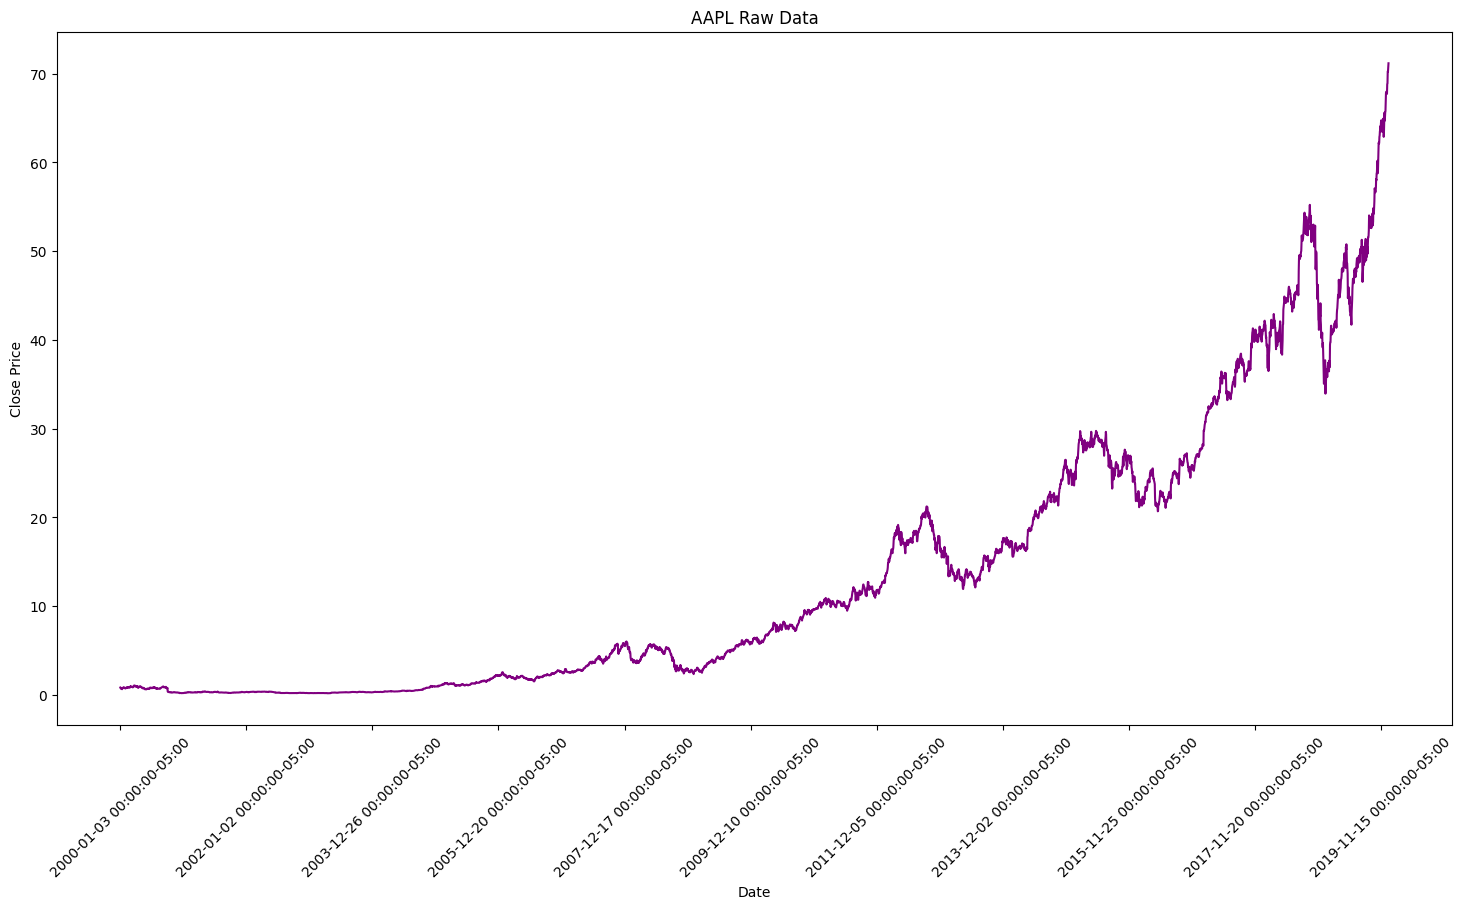

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 0.0002330692 (+/- 0.0000689219)


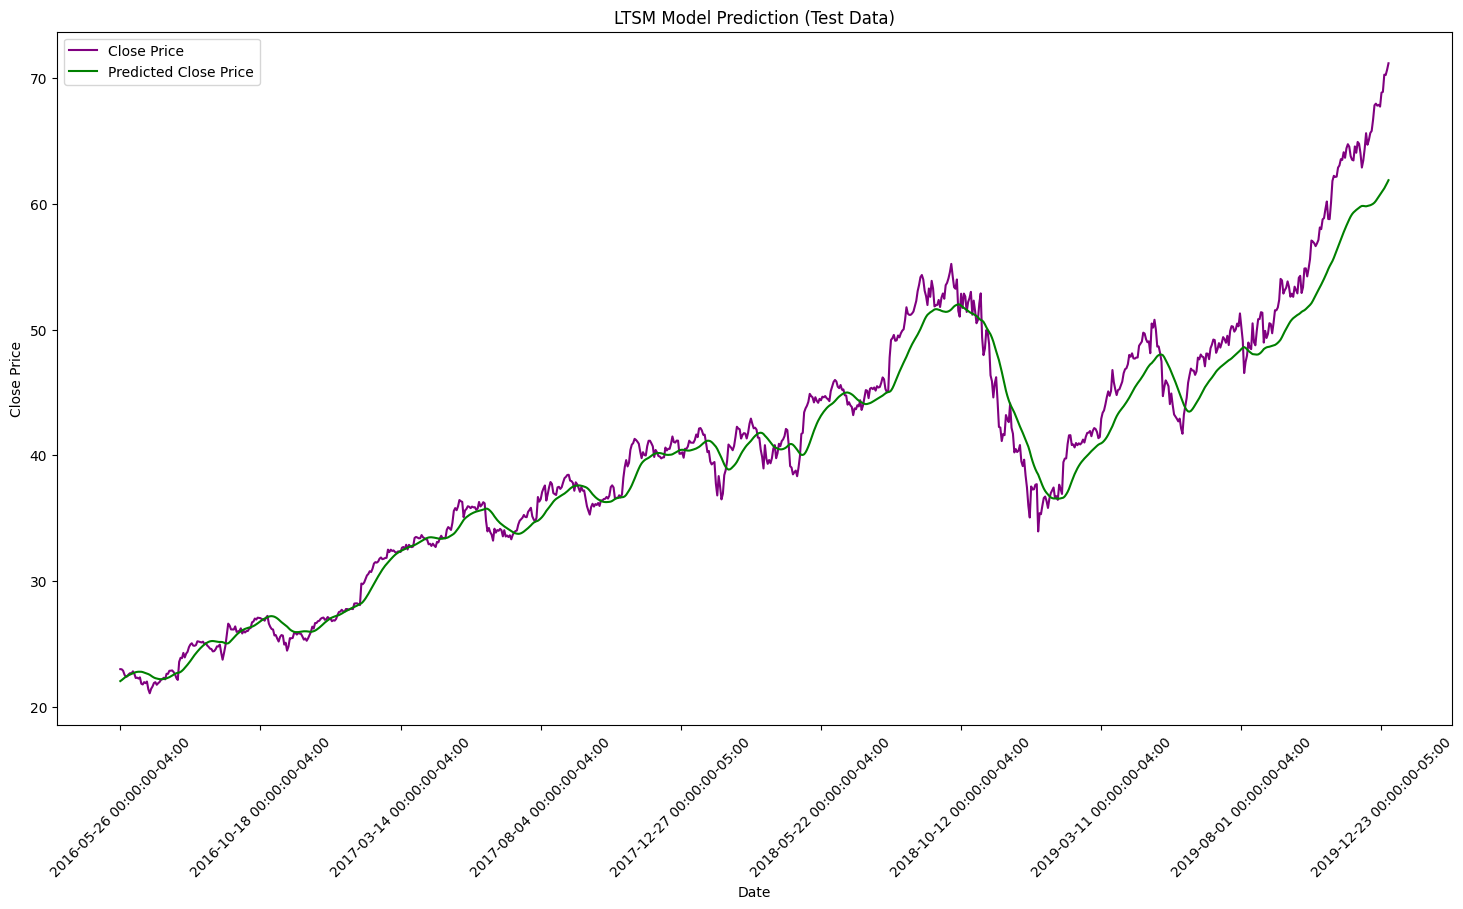

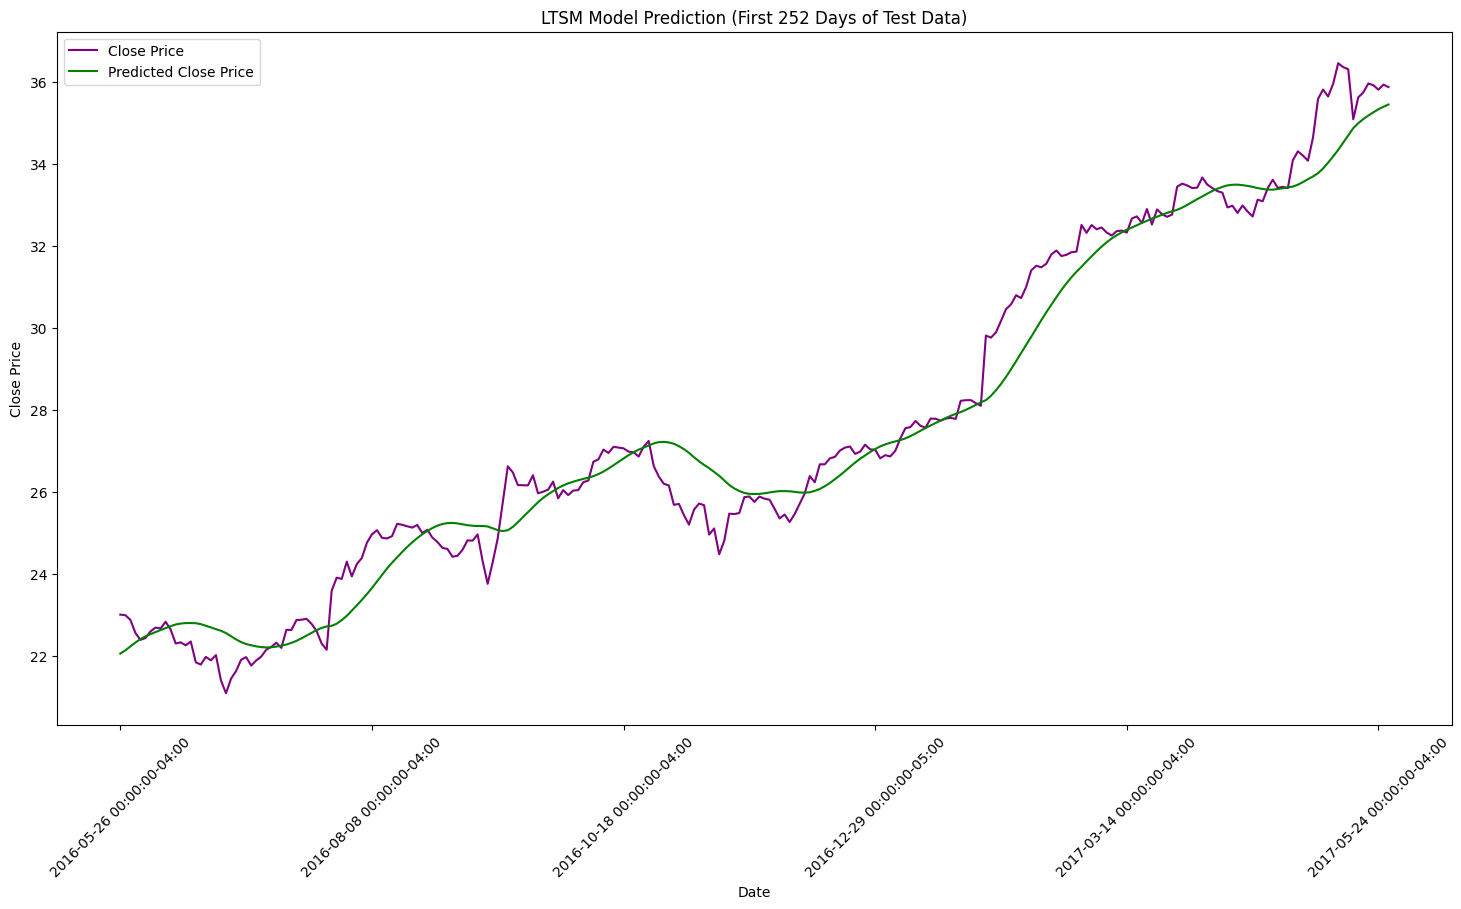

Start                     2016-05-26 00:00...
End                       2017-05-26 00:00...
Duration                    365 days 00:00:00
Exposure Time [%]                   99.209486
Equity Final [$]                  8443.148229
Equity Peak [$]                  11281.581517
Return [%]                         -15.568518
Buy & Hold Return [%]               55.912365
Return (Ann.) [%]                  -15.512023
Volatility (Ann.) [%]               15.274667
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.588293
Avg. Drawdown [%]                   -7.952826
Max. Drawdown Duration      212 days 00:00:00
Avg. Drawdown Duration       60 days 00:00:00
# Trades                                  159
Win Rate [%]                        41.509434
Best Trade [%]                       7.587122
Worst Trade [%]                     -7.744395
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p16032', ...)

In [94]:
#MAIN 

class LSTMThresholdStrategy(Strategy):
    
    threshold = 0.01

    def init(self):
        self.BUY_THRESHOLD = self.threshold 
        self.SELL_THRESHOLD = -self.threshold
        #store predicted price change as an indicator
        self.predicted_change = self.I(self.calculate_predicted_change, name='percentage change')

    def calculate_predicted_change(self):
        #calculate the percentage change between consecutive predicted prices
        
        p_change =  ( self.data['Predicted'] - self.data['Close'] ) / self.data['Close'] 
        
        return p_change

    def next(self):
        #check if the predicted change exceeds the buy threshold
        if self.predicted_change[-1] > self.BUY_THRESHOLD:
            self.position.close() 
            self.buy()
        
        #check if the predicted change is below the sell threshold
        elif self.predicted_change[-1] < self.SELL_THRESHOLD:
            self.position.close()
            self.sell()


data = get_raw_data("AAPL", start_time="2000-01-01", end_time="2020-01-01") #can change to look at different stocks, start/end optional

factor_window = 252 #optimise #for calculating momentum and volatility 
lookback_window = 50 #optimise #'memory' of the model 
X_train, y_train, X_test, y_test, data, scaler = process_data(data, factor_window, lookback_window) 

#model = LTSM_model(X_train, y_train) #can comment out since no need to retrain every time if data/parameters not changed 
predictions = get_predictions(model, X_test, y_test)
final_data = rescale_data(predictions, data, scaler, lookback_window, y_test)
period = 253 #how long test period  
test_data = final_data[:period]

#plot rescaled data with predictions 
plt.figure(figsize = (18,9))
plt.title(f'LTSM Model Prediction (First {period-1} Days of Test Data)')
plt.xticks(range(0,test_data.shape[0],50),test_data.index[::50],rotation=45)
plt.plot(range(test_data.shape[0]), test_data['Close'], label='Close Price', color='purple')
plt.plot(range(test_data.shape[0]), test_data['Predicted'], label='Predicted Close Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#backtesting - only final 
bt = Backtest(test_data, LSTMThresholdStrategy, cash=10000, commission=0.001) 

output = bt.run()
print(output)

#plot results
bt.plot()


In [95]:
mylist = list(np.linspace(0.01, 0.08, num=100))
stats = bt.optimize(threshold=mylist, maximize='Equity Final [$]') #

stats, stats._strategy

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


(Start                     2016-05-26 00:00...
 End                       2017-05-26 00:00...
 Duration                    365 days 00:00:00
 Exposure Time [%]                   91.304348
 Equity Final [$]                 18603.590956
 Equity Peak [$]                  18857.100845
 Return [%]                           86.03591
 Buy & Hold Return [%]               55.912365
 Return (Ann.) [%]                   85.580005
 Volatility (Ann.) [%]               31.041369
 Sharpe Ratio                         2.756966
 Sortino Ratio                       10.611186
 Calmar Ratio                         14.76469
 Max. Drawdown [%]                   -5.796262
 Avg. Drawdown [%]                    -1.26635
 Max. Drawdown Duration       33 days 00:00:00
 Avg. Drawdown Duration        8 days 00:00:00
 # Trades                                    8
 Win Rate [%]                             75.0
 Best Trade [%]                      45.408513
 Worst Trade [%]                     -2.786172
 Avg. Trade [

Best threshold 0.058

In [110]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,469,22,74,21.305058,23.644931,1097.400462,0.109827,2016-06-28 00:00:00-04:00,2016-09-12 00:00:00-04:00,76 days 00:00:00
1,468,74,78,23.668576,26.517340,1333.221611,0.120361,2016-09-12 00:00:00-04:00,2016-09-16 00:00:00-04:00,4 days 00:00:00
2,-469,78,113,26.490822,25.127715,639.297528,0.051456,2016-09-16 00:00:00-04:00,2016-11-04 00:00:00-04:00,49 days 00:00:00
3,519,113,114,25.152842,25.486586,173.212739,0.013269,2016-11-04 00:00:00-04:00,2016-11-07 00:00:00-05:00,3 days 01:00:00
4,519,114,118,25.512072,24.801262,-368.910543,-0.027862,2016-11-07 00:00:00-05:00,2016-11-11 00:00:00-05:00,4 days 00:00:00
5,518,118,120,24.826063,24.673923,-78.808568,-0.006128,2016-11-11 00:00:00-05:00,2016-11-15 00:00:00-05:00,4 days 00:00:00
6,518,120,121,24.698597,24.704025,2.811566,0.000220,2016-11-15 00:00:00-05:00,2016-11-16 00:00:00-05:00,1 days 00:00:00
7,517,121,252,24.728729,35.957677,5805.366160,0.454085,2016-11-16 00:00:00-05:00,2017-05-26 00:00:00-04:00,190 days 23:00:00


In [105]:
#save model if works well
model_name = 'model3.keras'#name of model 
model.save(model_name)

### Loading saved model

In [19]:
#load models
new_model = tf.keras.models.load_model('model1.keras')

#show the model architecture
new_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,155 (363.89 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,104 (242.60 KB)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.0002527711 (+/- 0.0000775010)
MSE: 0.0002527711 (+/- 0.0000775010)


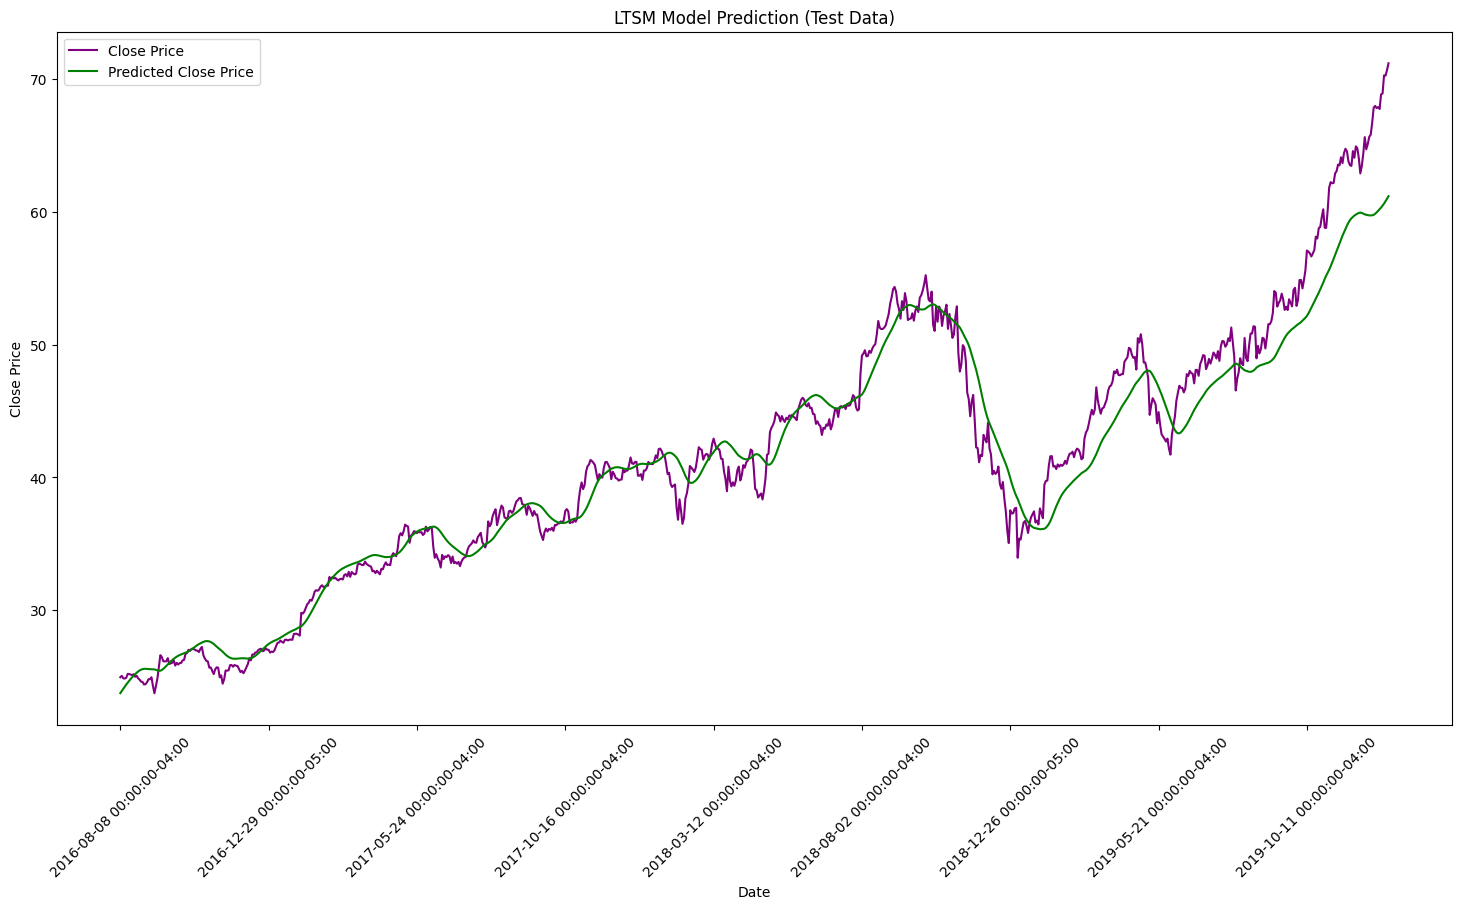

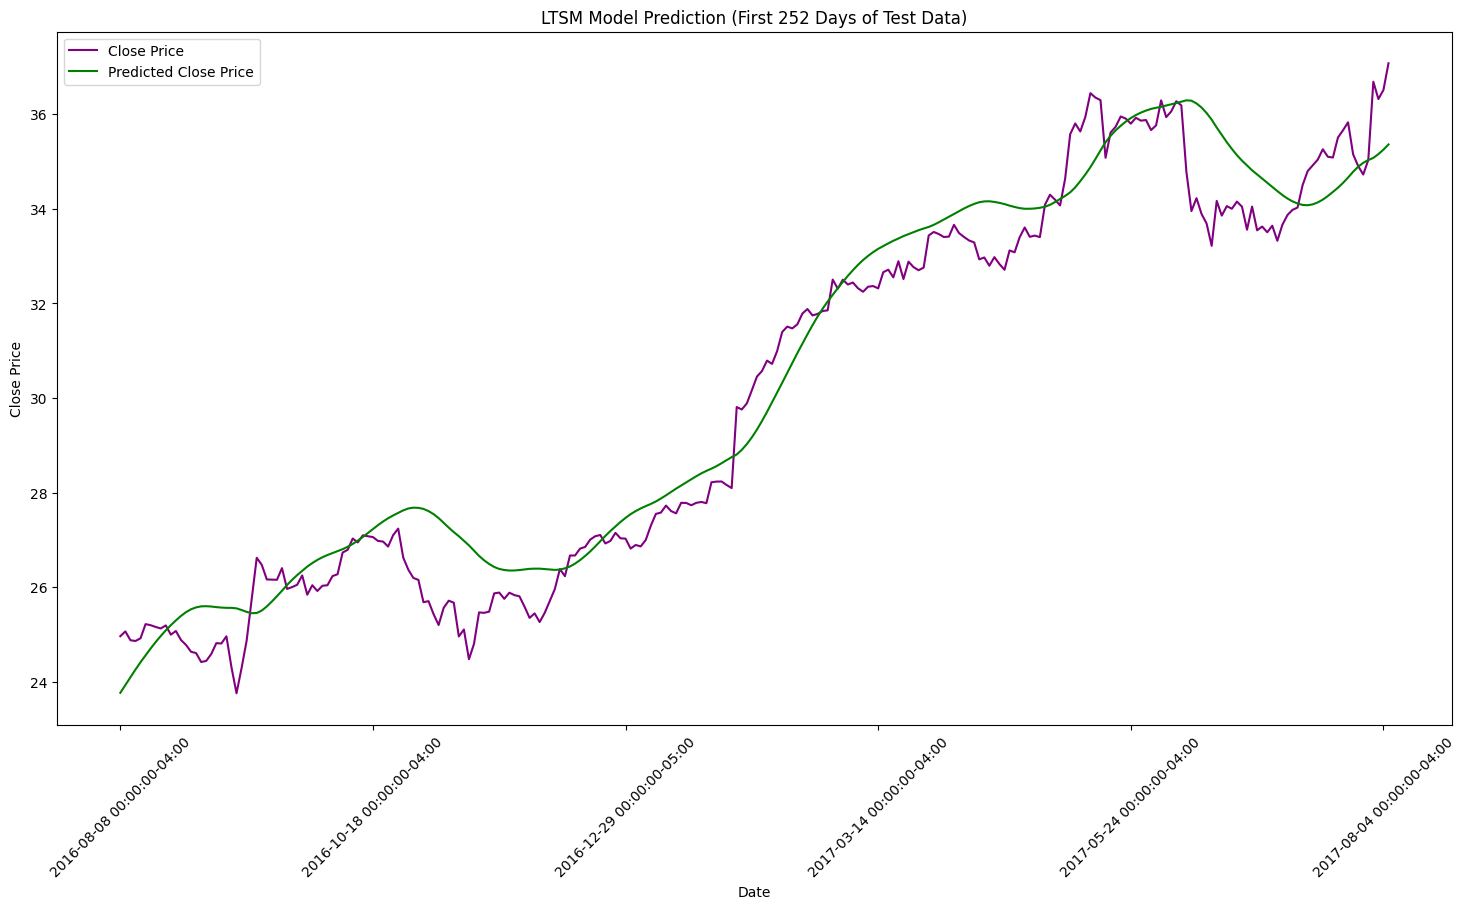

Start                     2016-08-08 00:00...
End                       2017-08-07 00:00...
Duration                    364 days 00:00:00
Exposure Time [%]                    90.47619
Equity Final [$]                 10099.652352
Equity Peak [$]                  13337.334708
Return [%]                           0.996524
Buy & Hold Return [%]               48.545831
Return (Ann.) [%]                    0.996524
Volatility (Ann.) [%]               17.590432
Sharpe Ratio                         0.056651
Sortino Ratio                        0.088984
Calmar Ratio                         0.041051
Max. Drawdown [%]                  -24.275333
Avg. Drawdown [%]                   -3.069547
Max. Drawdown Duration      187 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                   33
Win Rate [%]                        27.272727
Best Trade [%]                      19.970106
Worst Trade [%]                    -13.654098
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p3288', ...)

In [22]:
predictions = get_predictions(new_model, X_test, y_test)

mse = (1/len(predictions))*((np.concatenate(predictions) - y_test**2))
print(f"MSE: {mse.mean():0.10f} (+/- {mse.std():0.10f})")

final_data = rescale_data(predictions, data, scaler, lookback_window, y_test)
period = 252 #how long test period  
test_data = final_data[:period]

#plot rescaled data with predictions 
plt.figure(figsize = (18,9))
plt.title(f'LTSM Model Prediction (First {period} Days of Test Data)')
plt.xticks(range(0,test_data.shape[0],50),test_data.index[::50],rotation=45)
plt.plot(range(test_data.shape[0]), test_data['Close'], label='Close Price', color='purple')
plt.plot(range(test_data.shape[0]), test_data['Predicted'], label='Predicted Close Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#backtesting 
bt_op = Backtest(test_data, LSTMThresholdStrategy, cash=10000, commission=0.001) 

output = bt.run()
print(output)

#plot results
bt.plot()

In [36]:
mylist = list(np.linspace(0.005, 0.08, num=100))
stats = bt_op.optimize(threshold=mylist, maximize='Equity Final [$]')

stats

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


Start                     2016-08-08 00:00...
End                       2017-08-07 00:00...
Duration                    364 days 00:00:00
Exposure Time [%]                   90.873016
Equity Final [$]                 14879.836076
Equity Peak [$]                  14887.401179
Return [%]                          48.798361
Buy & Hold Return [%]               48.545831
Return (Ann.) [%]                   48.798361
Volatility (Ann.) [%]               25.305396
Sharpe Ratio                         1.928378
Sortino Ratio                        4.957388
Calmar Ratio                         4.392884
Max. Drawdown [%]                  -11.108501
Avg. Drawdown [%]                   -1.635608
Max. Drawdown Duration       82 days 00:00:00
Avg. Drawdown Duration       14 days 00:00:00
# Trades                                   22
Win Rate [%]                        59.090909
Best Trade [%]                       38.95016
Worst Trade [%]                     -3.670009
Avg. Trade [%]                    

In [38]:
stats._strategy

<Strategy LSTMThresholdStrategy(threshold=0.005)>

### Final Test 

Test on unseen data with parameters found through optimisation

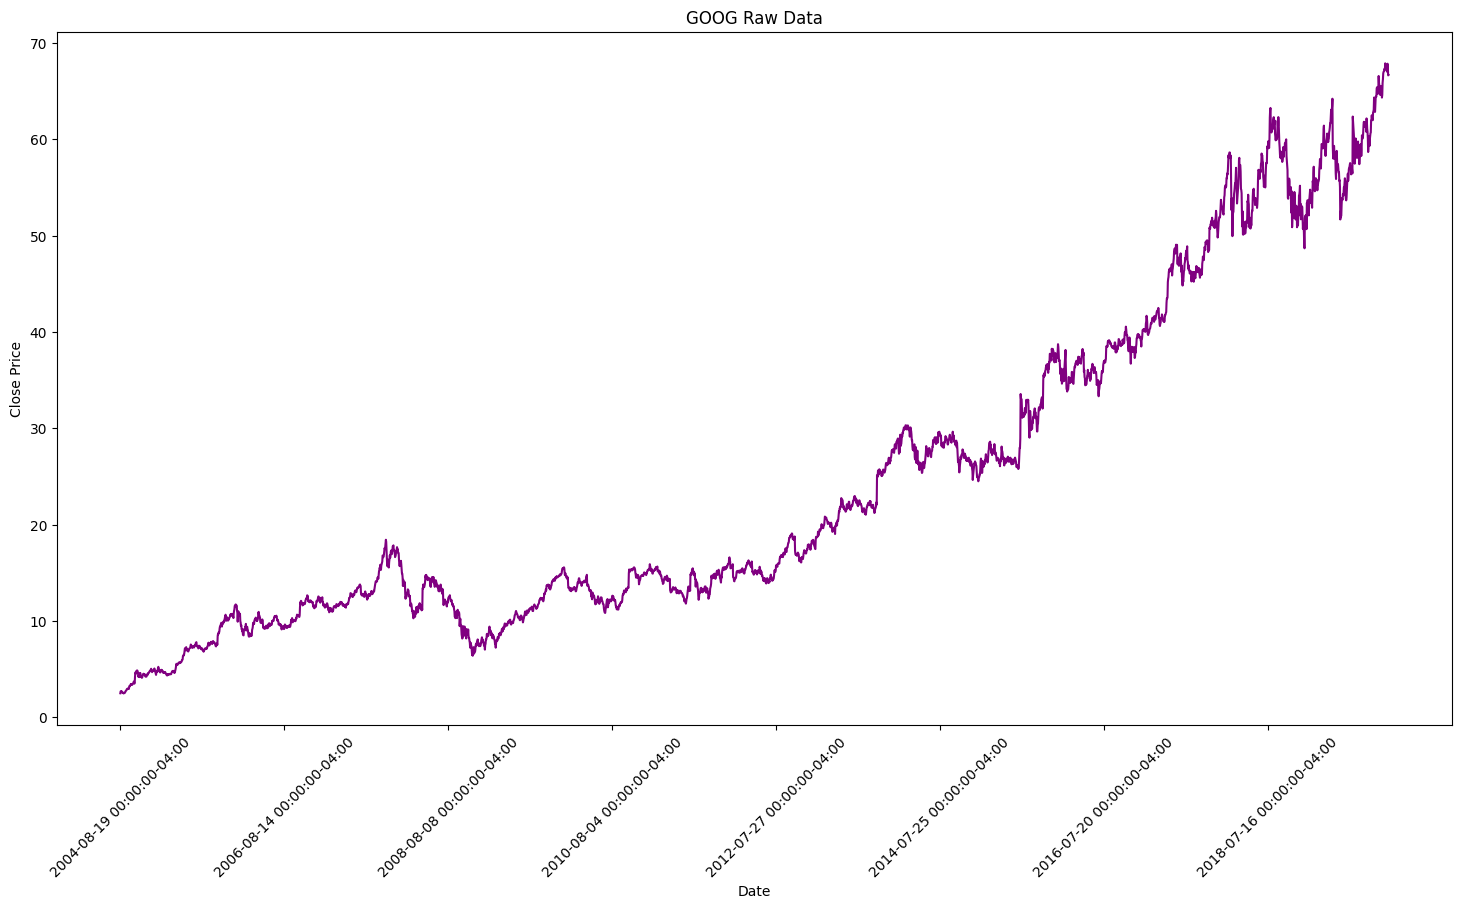

Epoch 1/20


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0050 - val_loss: 4.1996e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2261e-04 - val_loss: 3.1200e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4817e-04 - val_loss: 7.4274e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4757e-04 - val_loss: 8.5968e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6622e-04 - val_loss: 4.6361e-04
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.0002341678 (+/- 0.0000954687)


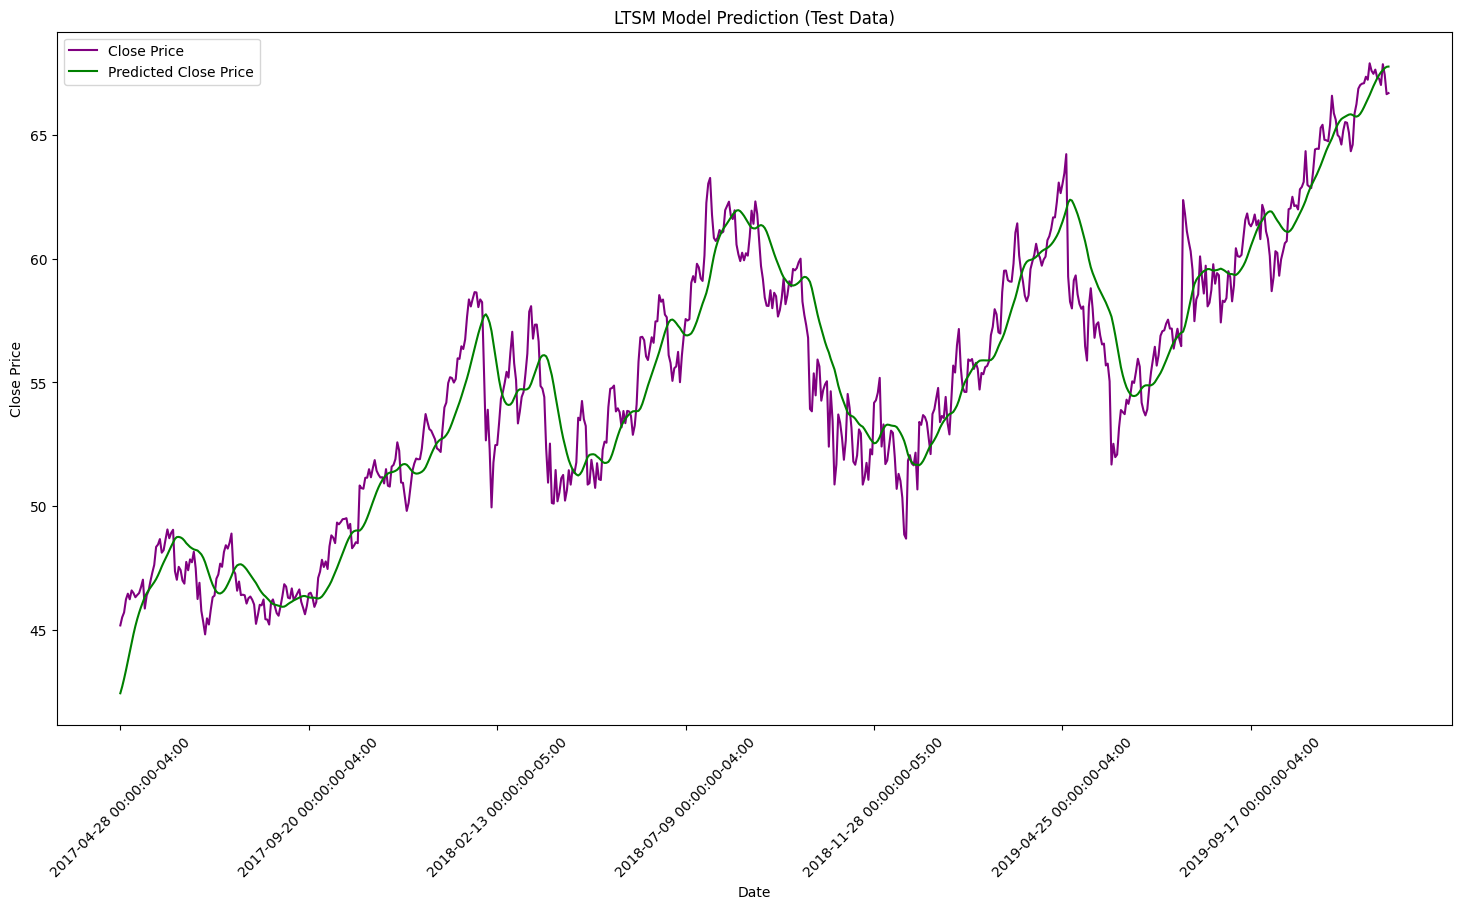

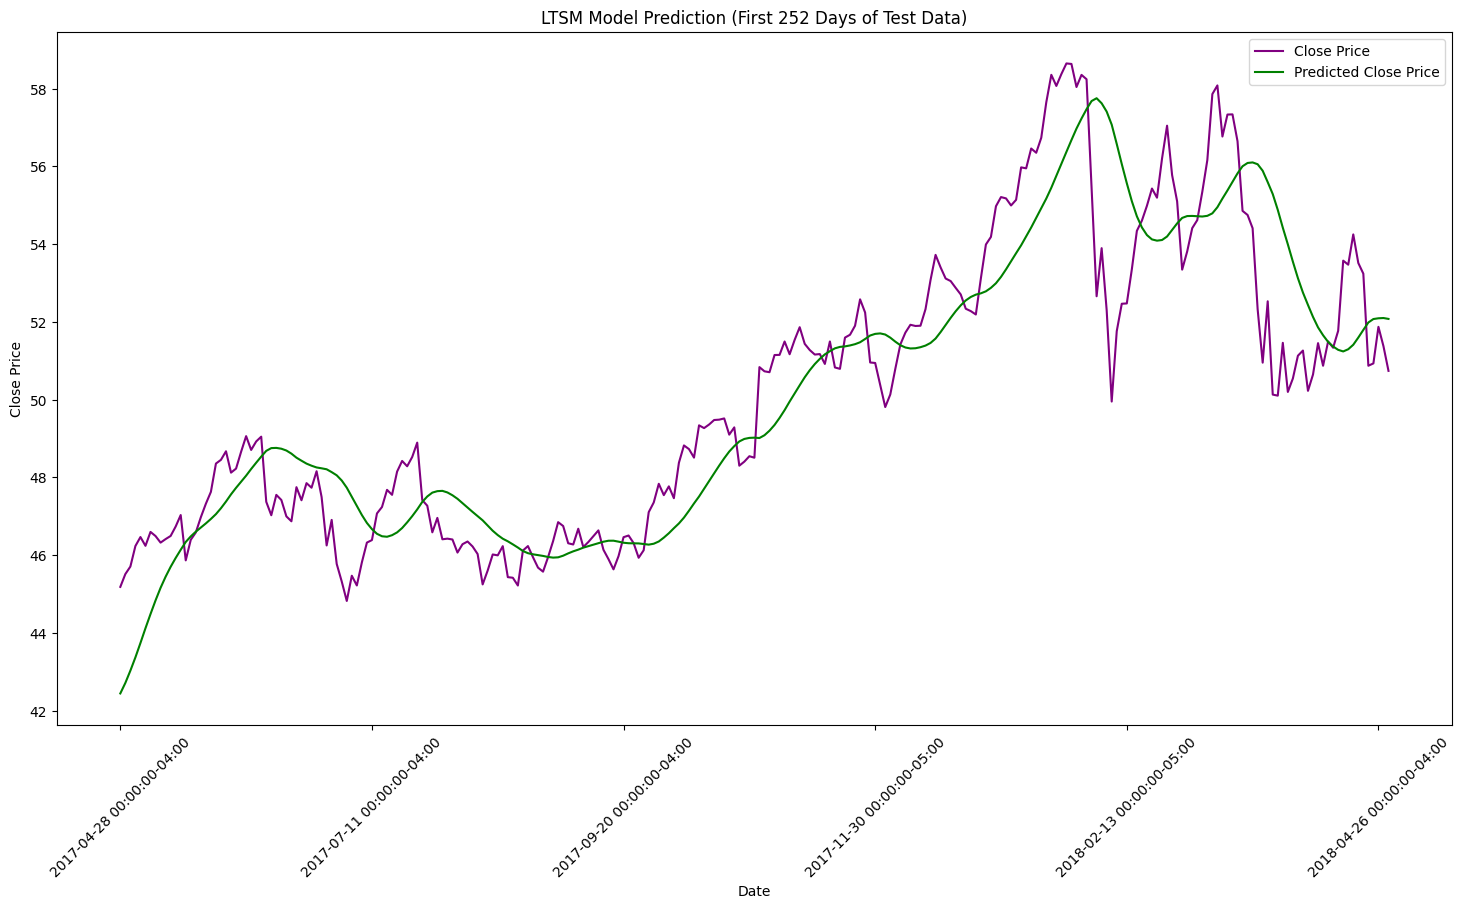

Start                     2017-04-28 00:00...
End                       2018-04-30 00:00...
Duration                    367 days 00:00:00
Exposure Time [%]                   99.209486
Equity Final [$]                 14769.204062
Equity Peak [$]                  14899.774592
Return [%]                          47.692041
Buy & Hold Return [%]                12.29303
Return (Ann.) [%]                   47.464572
Volatility (Ann.) [%]                32.19713
Sharpe Ratio                         1.474186
Sortino Ratio                         3.29113
Calmar Ratio                         3.156929
Max. Drawdown [%]                  -15.035046
Avg. Drawdown [%]                   -2.676765
Max. Drawdown Duration       79 days 00:00:00
Avg. Drawdown Duration       16 days 00:00:00
# Trades                                   24
Win Rate [%]                             50.0
Best Trade [%]                      13.794562
Worst Trade [%]                     -6.208563
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p20288', ...)

In [107]:
class OptimisedLSTMThresholdStrategy(Strategy):
    
    threshold = 0.058

    def init(self):
        self.BUY_THRESHOLD = threshold 
        self.SELL_THRESHOLD = -threshold
        #store predicted price change as an indicator
        self.predicted_change = self.I(self.calculate_predicted_change, name='percentage change')

    def calculate_predicted_change(self):
        #calculate the percentage change between consecutive predicted prices
        
        p_change =  ( self.data['Predicted'] - self.data['Close'] ) / self.data['Close'] 
        
        return p_change

    def next(self):
        #check if the predicted change exceeds the buy threshold
        if self.predicted_change[-1] > self.BUY_THRESHOLD:
            self.position.close() 
            self.buy()
        
        #check if the predicted change is below the sell threshold
        elif self.predicted_change[-1] < self.SELL_THRESHOLD:
            self.position.close()
            self.sell()


new_data = get_raw_data("GOOG", start_time="2000-01-01", end_time="2020-01-01") 


factor_window = 252 #for calculating momentum and volatility 
lookback_window = 50 #'memory' of the model 
X_train, y_train, X_test, y_test, data, scaler = process_data(new_data, factor_window, lookback_window) 

new_model = LTSM_model(X_train, y_train)
predictions = get_predictions(new_model, X_test, y_test)
final_data = rescale_data(predictions, data, scaler, lookback_window, y_test)
period = 253 #how long test period  
test_data = final_data[:period]

#plot rescaled data with predictions 
plt.figure(figsize = (18,9))
plt.title(f'LTSM Model Prediction (First {period-1} Days of Test Data)')
plt.xticks(range(0,test_data.shape[0],50),test_data.index[::50],rotation=45)
plt.plot(range(test_data.shape[0]), test_data['Close'], label='Close Price', color='purple')
plt.plot(range(test_data.shape[0]), test_data['Predicted'], label='Predicted Close Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#backtesting 
bt = Backtest(test_data, OptimisedLSTMThresholdStrategy, cash=10000, commission=0.001) 

output = bt.run()
print(output)

#plot results
bt.plot()
